In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import load_logging_data
from utils.assemble_model import build_model
from utils.layer import DecompositionLayer
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.sysconfig.get_build_info())
print(tf.config.list_physical_devices('GPU'))

True
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_dataset = load_logging_data(data_root_path='data/train')
val_dataset = load_logging_data(data_root_path='data/val')

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train_dataset['Data_Type'] = 'train'
val_dataset['Data_Type'] = 'validation'

dataset = pd.concat([train_dataset, val_dataset], axis=0)
dataset.reset_index(drop=True, inplace=True)

In [5]:
dataset

,Time 1 - default sample rate,BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 2 CH=151,MX840B_CH 3 CH=152,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation


In [6]:
angle_name_list = list(dataset.columns)[22:24] + list(dataset.columns)[26:28]
print(angle_name_list)

pressure_name_list = list(dataset.columns)[18:20] + list(dataset.columns)[24:26]
print(pressure_name_list)

new_angle_name_list = ['Mast_X(deg)', 'Mast_Y(deg)', 'Base_X(deg)', 'Base_Y(deg)']
new_pressure_name_list = ['P1(bar)', 'P2(bar)', 'P3(bar)', 'P4(bar)']

dataset.rename(columns={'Time  1 - default sample rate': 'Time(sec)'}, inplace=True)
dataset.rename(columns={'caloutput_drill_depth CH=26': 'Drill_Depth(m)'}, inplace=True)
dataset.rename(columns={'caloutput_rotate_velocity CH=25': 'Drill_Rotation(RPM)'}, inplace=True)

for angle_name, new_angle_name in zip(angle_name_list, new_angle_name_list):
    dataset.rename(columns={angle_name: new_angle_name}, inplace=True)

for pressure_name, new_pressure_name in zip(pressure_name_list, new_pressure_name_list):
    dataset.rename(columns={pressure_name: new_pressure_name}, inplace=True)

dataset[new_pressure_name_list[3]] = np.clip(dataset[new_pressure_name_list[3]].to_numpy(), 0, 300)
dataset['Work_Load'] = (dataset[new_pressure_name_list[3]] * (dataset['Drill_Rotation(RPM)']))
dataset['Drill_Depth(m)'] = dataset['Drill_Depth(m)']/10

['angle_Mast_X CH=27', 'angle_Mast_Y CH=28', 'angle_base_X CH=31', 'angle_base_Y CH=32']
['pressure_1_pressure_transmitter_1_drive1 CH=23', 'pressure_1_pressure_transmitter_2_drive2 CH=24', 'pressure_2_pressure_transmitter_6_cyl_1 CH=29', 'pressure_3_pressure_transmitter_7_cyl_2 CH=30']


In [7]:
for angle_name in new_angle_name_list:
    dataset[angle_name] = dataset[angle_name].clip(lower=-3, upper=3)

dataset[new_angle_name_list].describe()

,Mast_X(deg),Mast_Y(deg),Base_X(deg),Base_Y(deg)
count,21374.000000,21374.000000,21374.000000,21374.000000
mean,0.248030,-0.842360,-0.633260,0.007285
std,0.274738,0.390338,0.199366,0.318868
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,0.200000,-0.900000,-0.700000,-0.100000
50%,0.300000,-0.800000,-0.700000,0.100000
75%,0.400000,-0.700000,-0.600000,0.200000
max,3.000000,0.900000,1.800000,1.400000


In [8]:
dataset['Work_Load'] = dataset['Work_Load']/1100
dataset['Work_Load'] = dataset['Work_Load']*100

In [9]:
feature_name_list = new_angle_name_list + [new_pressure_name_list[3]] + ['Drill_Rotation(RPM)']
dataset[feature_name_list+['Work_Load']].describe()

,Mast_X(deg),Mast_Y(deg),Base_X(deg),Base_Y(deg),P4(bar),Drill_Rotation(RPM),Work_Load
count,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000,21374.000000
mean,0.248030,-0.842360,-0.633260,0.007285,17.270982,6.226958,10.350396
std,0.274738,0.390338,0.199366,0.318868,2.722428,7.010610,11.770553
min,-3.000000,-3.000000,-3.000000,-3.000000,0.000000,0.000000,0.000000
25%,0.200000,-0.900000,-0.700000,-0.100000,16.630000,0.000000,0.000000
50%,0.300000,-0.800000,-0.700000,0.100000,18.000000,4.000000,7.036364
75%,0.400000,-0.700000,-0.600000,0.200000,18.680000,10.000000,16.363636
max,3.000000,0.900000,1.800000,1.400000,23.430000,50.000000,94.090909


In [10]:
target_name = 'Work_Load_Cls'
bool_arr = dataset['Work_Load'].to_numpy() >= 60
bool_arr = bool_arr.astype(np.int32)

dataset = pd.concat([dataset, pd.DataFrame(bool_arr, columns=[target_name])], axis=1)

In [11]:
dataset

,Time(sec),BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type,Work_Load,Work_Load_Cls
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train,0.0,0
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0,0
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0,0
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0,0
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0,0
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0,0
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0,0
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0,0


In [12]:
dataset_arr = dataset[feature_name_list+[target_name]].to_numpy()

n_samples = 2000
max_len = 250

random_start_idx = np.random.randint(low=0, high=dataset_arr.shape[0]-max_len*2, size=n_samples)
random_len_idx = np.random.randint(low=max_len*1, high=max_len*2, size=n_samples)

augment_train_dataset_arr = np.empty(shape=(0, dataset_arr.shape[1]))

for i, j in zip(random_start_idx, random_len_idx):
    augment_train_dataset_arr = np.concatenate([augment_train_dataset_arr, dataset_arr[i:i+j, :]], axis=0)

print(augment_train_dataset_arr.shape)
print((augment_train_dataset_arr.itemsize * augment_train_dataset_arr.size)/(1024**2))

(752214, 7)
40.17256164550781


In [13]:
seq_len = 30
pred_distance = 25

train_feature, train_target = create_seq_dataset_multiple_input_single_output(data=augment_train_dataset_arr,
                                                                              seq_len=seq_len,
                                                                              pred_distance=pred_distance,
                                                                              target_idx_pos=augment_train_dataset_arr.shape[1]-1)
train_target = np.squeeze(train_target)
print(train_feature.shape, train_target.shape)

print((train_feature.itemsize*train_feature.size)/(1024**2))
print((train_target.itemsize*train_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/752189 [00:00<?, ?it/s]

(752160, 30, 6) (752160,)
1032.9345703125
5.738525390625


In [14]:
val_feature, val_target = create_seq_dataset_multiple_input_single_output(data=dataset_arr,
                                                                          seq_len=seq_len,
                                                                          pred_distance=pred_distance,
                                                                          target_idx_pos=dataset_arr.shape[1]-1)
val_target = np.squeeze(val_target)
print(val_feature.shape, val_target.shape)

print((val_feature.itemsize*val_feature.size)/(1024**2))
print((val_target.itemsize*val_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/21349 [00:00<?, ?it/s]

(21320, 30, 6) (21320,)
29.278564453125
0.16265869140625


In [15]:
model = build_model(input_shape=(train_feature.shape[1:]), d_dims=64, dropout_rate=0.5, learning_rate=0.001)
#model.summary()

In [16]:
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])

print("--- 모델 파라미터 요약 ---")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {int(trainable_params):,}")
print(f"Non-trainable params: {int(non_trainable_params):,}")

--- 모델 파라미터 요약 ---
Total params: 607,261
Trainable params: 606,613
Non-trainable params: 648


In [17]:
bytes_per_param_float32 = 4
total_bytes = total_params * bytes_per_param_float32

total_kb = total_bytes / 1024
total_mb = total_kb / 1024

print(f"--- 32비트 (float32) 기준 계산 ---")
print(f"총 파라미터 수: {total_params:,}")
print(f"총 용량 (MB): {total_mb:.2f} MB")

--- 32비트 (float32) 기준 계산 ---
총 파라미터 수: 607,261
총 용량 (MB): 2.32 MB


In [18]:
#keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, verbose=0)
csv_logger = keras.callbacks.CSVLogger(filename=f'result/log_{pred_distance}.csv', append=False, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath=f'models/model_{pred_distance}.keras', monitor="val_loss", verbose=2,
                                                  save_best_only=True, save_weights_only=False, mode="min", save_freq="epoch",
                                                  initial_value_threshold=None)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=99999,
          batch_size=3000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point, tensorboard_callback])

In [20]:
model = keras.models.load_model(f'models/model_{pred_distance}.keras', custom_objects={'DecompositionLayer': DecompositionLayer})
val_pred = model.predict(val_feature, verbose=1)
val_pred = np.squeeze(val_pred)

667/667 [==============================] - 13s 17ms/step


<Axes: >

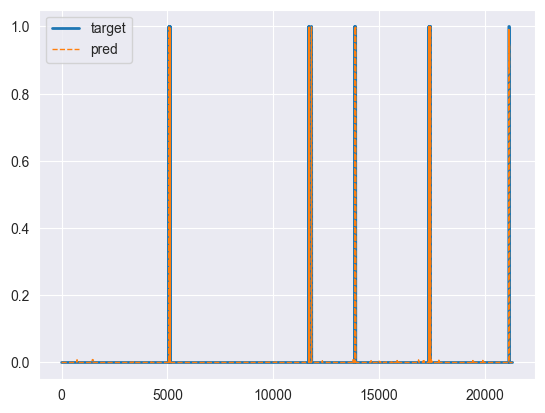

In [22]:
sns.lineplot(val_target, label='target', linewidth=2)
sns.lineplot(val_pred, label='pred', linewidth=1, linestyle='--')

#plt.xlim(1300, 1400)

In [25]:
train_log_data = pd.read_csv('result/log_25.csv')

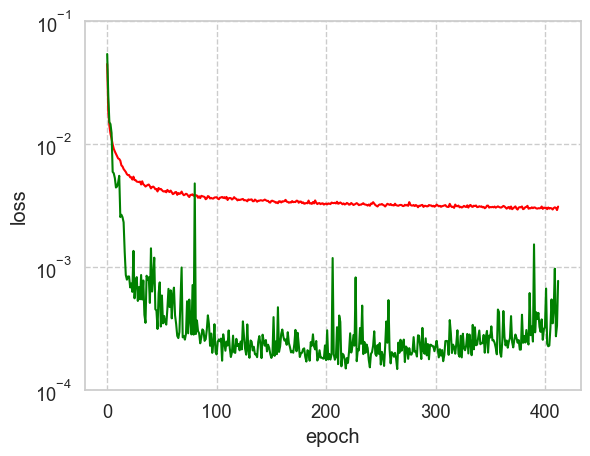

In [26]:
sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(data=train_log_data, x='epoch', y='loss', color='red')
sns.lineplot(data=train_log_data, x='epoch', y='val_loss', color='green')

plt.ylim(0.0001, 0.1)
plt.yscale('log')